# Custom Biomedical Dataset으로 Vision Transformer 모델 Fine-tuning 하기
_작성자 : [Emre Albayrak](https://github.com/emre570)_

_번역자: [Hyun Ji Jeon](https://github.com/HyunZ118)_

&nbsp;

이 가이드는 Vision Transformer(ViT) 모델을 Custom Biomedical Dataset 에 Fine-tuning하는 과정을 설명합니다. 이 과정에서 데이터셋 로딩 및 전처리, 데이터 분할에 따른 이미지 변환 설정, ViT 모델 구성 및 초기화, 평가 및 시각화 도구를 포함한 학습 과정 정의 단계가 포함됩니다.  

&nbsp;
## 데이터셋 정보
Custom Dataset은 수작업으로 제작되었으며, 총 780장의 이미지와 benign(양성), malignant(악성), normal(정상) 총 3개의 클래스를 포함합니다.

![attachment:datasetinfo.png](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/102d6c23e6cc24db857fbc60186461ded6cdfb75/datasetinfo.png)

## 모델 정보
우리가 Fine-tuning 할 모델은 Google의 [`"vit-large-patch16-224"`](https://huggingface.co/google/vit-large-patch16-224)입니다. 이 모델은 ImageNet-21k(1,400만 장의 이미지, 21,843개의 클래스)으로 사전학습 되었으며, ImageNet 2012(100만 장의 이미지, 1,000개 클래스)로 해상도 224x224에서 Fine-tuning 되었습니다. Google은 이외에도 다양한 이미지 크기와 패치 크기를 가진 여러 ViT 모델을 보유하고 있습니다.


그럼 이제 시작해보겠습니다! 🤗

## 시작
먼저 필요한 라이브러리들을 설치해야합니다.

In [ ]:
# !pip install datasets transformers accelerate torch torchvision scikit-learn matplotlib wandb

In [ ]:
# !pip install --upgrade datasets # Updated by HJ (colab 환경에서 실험 중일 경우 최신 버전 사용을 위해 업그레이드 필요)

(선택 사항) 모델을 Hugging Face Hub에 업로드할 예정이므로 먼저 로그인해야 합니다.

In [2]:
#from huggingface_hub import notebook_login
#notebook_login()

## 데이터셋 준비
`datasets` 라이브러리는 데이터셋에서 이미지와 클래스를 자동으로 불러옵니다. 자세한 내용은 [이 링크](https://huggingface.co/docs/datasets/image_load)를 참고하세요.

In [4]:
from datasets import load_dataset

dataset = load_dataset("emre570/breastcancer-ultrasound-images")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 624
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

데이터셋을 불러왔지만, 해당 데이터셋에는 검증 세트가 분할되어 있지 않은 상황입니다.

검증 세트를 만들기 위해 테스트 세트의 크기를 기준으로 훈련 세트의 일부를 나누어 검증 세트를 생성하려고 합니다.

그 후 기존 훈련 세트를 새로운 훈련 세트와 검증 세트로 분할합니다.

In [ ]:
# 각 세트의 데이터 수를 구해봅니다
test_num = len(dataset["test"])
train_num = len(dataset["train"])

val_size = test_num / train_num

train_val_split = dataset["train"].train_test_split(test_size=val_size)
train_val_split

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

분할된 훈련 세트를 준비했습니다. 이제 이를 테스트 세트와 함께 병합해보겠습니다.

In [6]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": train_val_split["train"],
    "validation": train_val_split["test"],
    "test": dataset["test"]
})
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 468
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 156
    })
})

좋습니다! 이제 데이터셋 준비가 완료되었네요 👍🏻

나중에 쉽게 참조할 수 있도록 각 하위 집합을 변수에 할당해 둡시다.

In [7]:
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

이미지를 확인해보면 `PIL.Image` 형식이며 이에 연결된 레이블이 함께 존재하는 것을 확인할 수 있습니다.

In [ ]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=558x475>,
 'label': 1}

훈련 세트의 특성도 확인할 수 있습니다.

In [9]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

데이터셋에서 각 클래스별로 하나씩 이미지를 출력해봅시다.

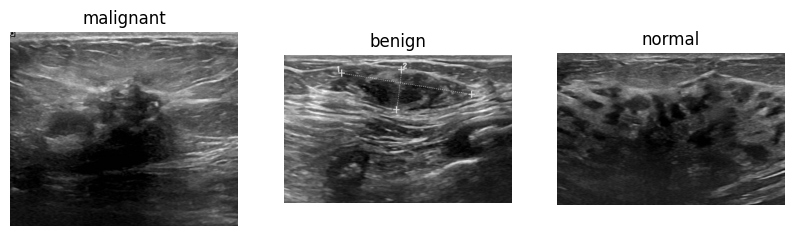

In [ ]:
import matplotlib.pyplot as plt

# 표시된 레이블을 추적할 수 있게 set를 초기화해줍니다
shown_labels = set()

# 그래프를 그리기 위해 figure를 초기화해줍니다
plt.figure(figsize=(10, 10))

# 데이터셋을 하나씩 살펴보면서 각 라벨마다 첫 번째 이미지를 그려줍니다
for i, sample in enumerate(train_ds):
    label = train_ds.features['label'].names[sample['label']]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features['label'].names), len(shown_labels) + 1)
        plt.imshow(sample['image'])
        plt.title(label)
        plt.axis('off')
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features['label'].names):
            break

plt.show()



## 데이터 전처리
데이터셋은 준비되었지만 파인튜닝을 위한 준비는 아직 완료되지 않았습니다. 아래와 같은 절차를 순차적으로 따라가보겠습니다!

- **레이블 매핑 (Label Mapping)** : 레이블 ID와 해당 클래스 이름 간의 매핑을 수행합니다. 이는 모델 학습과 평가 시 유용하게 사용됩니다.

- **이미지 전처리 (Image Processing)** : `ViTImageProcessor`를 사용해 입력 이미지의 크기를 표준화하고, 사전 학습된 모델에 맞는 정규화를 적용합니다. 또한, `torchvision`을 활용해 훈련, 검증, 테스트용으로 서로 다른 변환을 정의하여 모델의 일반화를 향상시킵니다.

- **변환 함수 정의 (Transform Functions)** : ViT 모델에 맞는 형식과 크기로 이미지를 변환하기 위한 함수를 구현합니다.

- **데이터 로딩 (Data Loading)** : 이미지와 라벨을 올바르게 배치할 수 있도록 사용자 정의 collate 함수를 설정하고, 학습 과정에서 효율적인 데이터 로딩과 배치를 위해 DataLoader를 구성합니다.

- **배치 준비 (Batch Preparation)** : 샘플 배치의 데이터 형태(shape)를 확인하여 변환이 제대로 되었는지, 그리고 모델 입력으로 사용할 준비가 되었는지 검증합니다.

### 레이블 매핑 (Label Mapping)

In [11]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label, id2label[train_ds[0]['label']]

({0: 'benign', 1: 'malignant', 2: 'normal'}, 'malignant')

### 이미지 전처리 (Image Processing)

In [12]:
from transformers import ViTImageProcessor

model_name = "google/vit-large-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

In [13]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Resize

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose([
    RandomResizedCrop(size),
    RandomHorizontalFlip(),
    ToTensor(),
    normalize,
])
val_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])
test_transforms = Compose([
    Resize(size),
    CenterCrop(size),
    ToTensor(),
    normalize,
])

### 변환 함수 생성 (Transform Functions)

In [14]:
def apply_train_transforms(examples):
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_val_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def apply_test_transforms(examples):
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

### 각 데이터셋에 변환 함수 적용

In [15]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [16]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant', 'normal'], id=None)}

In [17]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=558x475>,
 'label': 1,
 'pixel_values': tensor([[[ 0.0431,  0.0667,  0.0902,  ..., -0.2863, -0.2706, -0.2549],
          [ 0.0196,  0.0353,  0.0353,  ..., -0.3647, -0.3725, -0.3647],
          [ 0.0510,  0.0275,  0.0039,  ..., -0.3333, -0.3490, -0.3569],
          ...,
          [-0.9373, -0.9059, -0.8745,  ..., -0.7882, -0.7804, -0.7725],
          [-0.9059, -0.9059, -0.8824,  ..., -0.8196, -0.8118, -0.7961],
          [-0.8196, -0.8431, -0.8667,  ..., -0.8431, -0.8588, -0.8431]],
 
         [[ 0.0431,  0.0667,  0.0902,  ..., -0.2863, -0.2706, -0.2549],
          [ 0.0196,  0.0353,  0.0353,  ..., -0.3647, -0.3725, -0.3647],
          [ 0.0510,  0.0275,  0.0039,  ..., -0.3333, -0.3490, -0.3569],
          ...,
          [-0.9373, -0.9059, -0.8745,  ..., -0.7882, -0.7804, -0.7725],
          [-0.9059, -0.9059, -0.8824,  ..., -0.8196, -0.8118, -0.7961],
          [-0.8196, -0.8431, -0.8667,  ..., -0.8431, -0.8588, -0.8431]],


픽셀 값이 텐서로 잘 변환되었네요 👍🏻

### 데이터 로딩

In [18]:
import torch
from torch.utils.data import DataLoader

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

### 배치 준비

In [19]:
batch = next(iter(train_dl))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


완벽합니다👏🏻 이제 파인튜닝 진행을 위한 모든 준비가 되었습니다.

이어서 모델을 설정하고 파인튜닝하는 과정을 진행하겠습니다.

## 모델 파인튜닝

우선, 특정 레이블 매핑과 사전 학습 설정(pre-trained settings)을 사용해 모델을 초기화하고, 크기 불일치를 조정해줍니다. 그 다음, 학습 과정을 정의하기 위해 저장 전략, 배치 크기, 학습 epoch 등의 학습 파라미터를 설정하고, Weights & Biases를 통해 학습 결과를 로깅합니다.

이후 Hugging Face의 Trainer가 인스턴스화되어 학습과 평가를 관리하며, 커스텀 데이터 collator와 모델에 내장된 Processor를 함께 사용합니다. 마지막으로 학습이 완료된 모델을 테스트 데이터셋으로 평가하고, 정확도를 확인하기 위한 지표(metrics)를 출력합니다.


첫번째로, 모델을 먼저 호출해보겠습니다.

In [20]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(model_name, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([3, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


이 부분에서 언급하고 싶은 디테일이 있습니다.`ignore_mismatched_sizes` 파라미터에 주목해주세요 👀

사전 학습된(pre-trained) 모델을 새로운 데이터셋에 파인튜닝할 때, 종종 이미지의 입력 크기나 모델 구조(예: 분류 레이어의 클래스 수 등)가 원래 모델이 학습된 환경과 완전히 일치하지 않을 수 있습니다. 이러한 상황은 다양한 이유로 발생할 수 있습니다. 예를 들어 ImageNet처럼 자연 이미지로 학습된 모델을 의료 영상이나 특수 카메라 이미지처럼 전혀 다른 유형의 이미지에 적용하려고 할 때 발생하는데요.

이때, `ignore_mismatched_sizes` 를 `True` 로 설정하면, 사이즈가 일치하지 않더라도 오류 없이 레이어를 자동으로 조정해 사용할 수 있게 해줍니다.


예를 들어, 해당 모델은 1000개의 클래스로 학습되어 있어서 출력 크기가 `torch.Size([1000])` 이고 입력 또한 `torch.Size([1000])` 클래스를 기대합니다. 그런데 우리가 사용하는 데이터셋은 클래스가 3개 `torch.Size([3])`이고, 이 경우 모델에 직접 입력하면 클래스 수가 맞지 않기 때문에 오류가 발생하게 됩니다.

그다음 Google에서 제공하는 학습 인자(arguments)를 정의해봅시다.

(선택 사항) `report_to` 파라미터를 `wandb`로 설정했기 때문에, 평가 지표는 Weights & Biases(W&B)에 저장됩니다. W&B는 API 키를 요구하므로 계정과 API 키를 미리 생성해두어야 합니다. 만약 W&B를 사용하고 싶지 않다면, `report_to` 파라미터를 제거하면 됩니다.

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir = "output-models",
    #save_total_limit=2,
    #report_to="wandb",
    #save_strategy="epoch",
    #evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=40,
    weight_decay=0.01,
    #load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
    report_to="none"
)

"""
# Updated by HJ
(현재 환경에서 TrainingArguments가 해당 인자들을 인식하지 못하는 오류(TypeError)가 발생하여
최소한의 설정만으로 Trainer가 동작하도록 수정한 버전임. 
중간값 저장이나 자동 평가 없이 단순 학습만 수행됨.)
"""


'\n현재 환경에서 TrainingArguments가 해당 인자들을 인식하지 못하는 오류(TypeError)가 발생하여\n최소한의 설정만으로 Trainer가 동작하도록 수정한 버전임.\n(중간값 저장이나 자동 평가 없이 단순 학습만 수행됨.)\n'

이제 Trainer을 사용해 파인튜닝을 시작할 수 있습니다.



In [ ]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

| Epoch | Training Loss | Validation Loss | Accuracy |
|-------|---------------|-----------------|----------|
| 40    | 0.174700      | 0.596288        | 0.903846 |

파인튜닝이 완료되었습니다. 이제 테스트 세트를 사용해 모델을 평가해보겠습니다.

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

`{'test_loss': 0.3219967782497406, 'test_accuracy': 0.9102564102564102, 'test_runtime': 4.0543, 'test_samples_per_second': 38.478, 'test_steps_per_second': 9.619}`

### (선택 사항) 모델을 Hugging Face Hub에 업로드하기



`push_to_hub`을 사용하면 Hugging Face Hub에 모델을 업로드할 수 있습니다.

In [ ]:
model.push_to_hub("your_model_name")

좋습니다! 이제 결과를 시각화해볼까요?

## 결과
파인튜닝을 마쳤으니, 이제 모델이 각 클래스를 어떻게 예측했는지 확인해보겠습니다.

이를 위해 scikit-learn의 Confusion Matrix Display를 사용하고, Recall 점수도 함께 확인해보겠습니다.

### Confusion Matrix 란?
Confusion Matrix(혼동 행렬)는 알고리즘, 특히 지도 학습 모델이 실제 정답을 알고 있는 테스트 데이터에 대해 얼마나 잘 작동하는지를 시각적으로 보여주는 표 형식입니다.
예측된 라벨과 실제 라벨의 빈도를 나타내므로 분류 모델의 성능을 평가할 때 특히 유용합니다.

우리 모델의 Confusion Matrix를 시각화해봅시다.

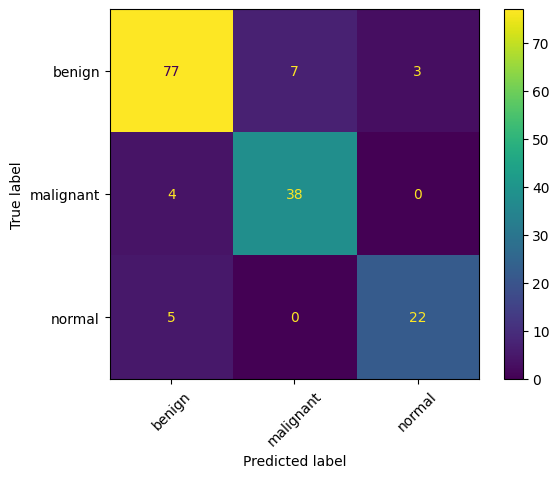

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

### Recall Score 란?
Recall Score(재현율)는 분류 작업에서 모델이 실제로 긍정 클래스(Positive Class)인 샘플을 얼마나 잘 찾아냈는지를 측정하는 성능 지표입니다.
즉, 실제 정답 중에서 모델이 올바르게 예측한 비율을 나타냅니다.

이제 scikit-learn을 사용해 재현율 점수를 출력해봅시다.

In [ ]:
from sklearn.metrics import recall_score

# Recall score 계산
# ‘None’으로 설정하면 각 클래스별로 개별적으로 recall을 계산합니다.
recall = recall_score(y_true, y_pred, average=None)

# 각 클래스별로 recall score를 출력합니다.
for label, score in zip(labels, recall):
    print(f'Recall for {label}: {score:.2f}')


Recall for benign: 0.89
Recall for malignant: 0.90
Recall for normal: 0.81


`Recall for benign: 0.90,
Recall for malignant: 0.86,
Recall for normal: 0.78`

## 결론
이 cookbook에서는 의료 데이터셋을 활용해 ViT 모델을 학습하는 과정을 다루었습니다.

데이터셋 준비, 이미지 전처리, 모델 구성, 학습, 평가, 그리고 결과 시각화까지의 핵심 단계들을 모두 포함하고 있습니다.

Hugging Face의 `transformers` 라이브러리와 `scikit-learn`, PyTorch의 `torchvision`을 활용하여 효율적인 모델 학습과 평가가 가능하며, 이를 통해 바이오 메디컬 이미지를 얼마나 정확하게 분류할 수 있는지에 대한 유용한 인사이트를 제공합니다.